## Imports and Setups

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import json, time

from gan import preprocessing, tadgan, postprocessing, utils

In [3]:
# set constants and hyperparameters

DATASET = 'data/output.csv'

# preprocessing
RESAMPLE_FREQ = 'H'  
WINDOW_SIZE = 100

# reconstruction model (TadGAN)
LATENT_DIM = 20
ENCODER_PARAMS = {'LSTM_units': 100}
GENERATOR_PARAMS = {'LSTM_units': 64, 'LSTM_dropout': 0.2}
LEARNING_RATE = 0.0001
EPOCHS = 100

# postprocessing
RECON_SCORE_PARAMS = {'dtw_window': 10}
ANOMALOUS_SEQ_PARAMS = {'sd_threshold': 4.0, 'pad': 50}

## Load Time Series Data

In [4]:
# import time series

x = pd.read_csv(DATASET)

x['time'] = pd.to_datetime(x['time'],format="%d-%m-%Y %H:%M:%S")
x.set_index('time', inplace=True)
x.index = pd.to_datetime(x.index)
x.sort_index(inplace=True)

print(f'Number of time stamps: {x.size}')
print(f'First 3 time stamps: {x.index[0]}, {x.index[1]}, {x.index[2]}')
print(f'Last 3 time stamps: {x.index[-3]}, {x.index[-2]}, {x.index[-1]}')

x.describe()

Number of time stamps: 216546
First 3 time stamps: 2020-07-01 10:11:35, 2020-07-02 15:51:53, 2020-07-02 15:54:35
Last 3 time stamps: 2023-09-07 12:48:25, 2023-09-07 13:09:13, 2023-09-07 13:12:28


,temperature
count,2.165460e+05
mean,-1.045808e+03
std,3.531911e+05
min,-1.162173e+08
25%,2.540000e+01
50%,2.810000e+01
75%,2.960000e+01
max,4.430000e+01


In [33]:
temp = x['temperature']
temp = temp[temp>=18]
temp = temp.resample('H').mean()
print(temp)

train = temp[(temp.index.year<2022) | ((temp.index.year==2022)&(temp.index.month<9))]
test = temp[(temp.index.year>2022) | ((temp.index.year==2022)&(temp.index.month>=9))]

train.head()

time
2020-07-02 15:00:00    24.366667
2020-07-02 16:00:00          NaN
2020-07-02 17:00:00          NaN
2020-07-02 18:00:00          NaN
2020-07-02 19:00:00    28.938889
                         ...    
2023-09-07 09:00:00    31.950000
2023-09-07 10:00:00    35.340000
2023-09-07 11:00:00    35.900000
2023-09-07 12:00:00    37.060000
2023-09-07 13:00:00    36.600000
Freq: H, Name: temperature, Length: 27887, dtype: float64


time
2020-07-02 15:00:00    24.366667
2020-07-02 16:00:00          NaN
2020-07-02 17:00:00          NaN
2020-07-02 18:00:00          NaN
2020-07-02 19:00:00    28.938889
Freq: H, Name: temperature, dtype: float64

## Prepare Training Data


In [6]:
# apply preprocessing pipeline

train, t, x_win, t_win = preprocessing.apply_pipeline(train, freq=RESAMPLE_FREQ, window_size=WINDOW_SIZE)

In [7]:
print(f'Number of rolling windows: {x_win.shape[0]}')
print(f'Start times of the first 3 windows: {t_win[:3]}')

Number of rolling windows: 18870
Start times of the first 3 windows: ['2020-07-02T15:00:00.000000000' '2020-07-02T16:00:00.000000000'
 '2020-07-02T17:00:00.000000000']


## Train Reconstruction Model (TadGAN)

In [10]:
# instantiate and configure a TadGAN model

params = {
    'input_dim': WINDOW_SIZE,
    'latent_dim': LATENT_DIM,
    'learning_rate': LEARNING_RATE,
    'encoder': ENCODER_PARAMS,
    'generator': GENERATOR_PARAMS
}

model = tadgan.TadGAN(**params)

In [23]:
# train the model

# t0 = time.time()
# model.fit(x_win, epochs=EPOCHS)
# t1 = time.time()

# model.save_model("./model/model_tran_100")

Epoch 1/100 (220.7 secs)
  Critic X Loss: 0.704106 [-5.06141994  4.40157876  0.13639472]
  Critic Z Loss: -0.272783 [ 0.22944562 -2.08512457  0.15828963]
  Encoder Generator Loss: 0.818358 [-4.33393389  2.60437653  0.25479152]
Epoch 2/100 (186.1 secs)
  Critic X Loss: -0.104563 [-5.96441642  5.46710849  0.03927446]
  Critic Z Loss: 0.877656 [ 0.50508716 -0.80031601  0.1172885 ]
  Encoder Generator Loss: -2.629868 [-5.3356376   0.92970824  0.17760616]
Epoch 3/100 (185.9 secs)
  Critic X Loss: -0.997950 [-4.01688653  2.79968261  0.02192537]
  Critic Z Loss: 1.518317 [ 0.6126815  -0.22788463  0.11335206]
  Encoder Generator Loss: -1.347610 [-2.66983374  0.29707977  0.10251441]
Epoch 4/100 (185.0 secs)
  Critic X Loss: -0.599419 [-4.76980843  3.93990271  0.02304865]
  Critic Z Loss: 1.607696 [0.39110653 0.10909324 0.11074961]
  Encoder Generator Loss: -3.053311 [-3.81082632 -0.03685233  0.07943673]
Epoch 5/100 (202.7 secs)
  Critic X Loss: -0.553202 [-11.10009608  10.18470199   0.03621923]

INFO:tensorflow:Assets written to: ./model/model_tran_100_encoder\assets


INFO:tensorflow:Assets written to: ./model/model_tran_100_encoder\assets


INFO:tensorflow:Assets written to: ./model/model_tran_100_generator\assets


INFO:tensorflow:Assets written to: ./model/model_tran_100_generator\assets


INFO:tensorflow:Assets written to: ./model/model_tran_100_critic_x\assets


INFO:tensorflow:Assets written to: ./model/model_tran_100_critic_x\assets


INFO:tensorflow:Assets written to: ./model/model_tran_100_critic_z\assets


INFO:tensorflow:Assets written to: ./model/model_tran_100_critic_z\assets


In [11]:
model.get_model("./model/model_tran_100")

In [24]:
# print(f'Total training time for {EPOCHS} epochs: {t1 - t0:.1f} secs')

Total training time for 100 epochs: 17773.6 secs


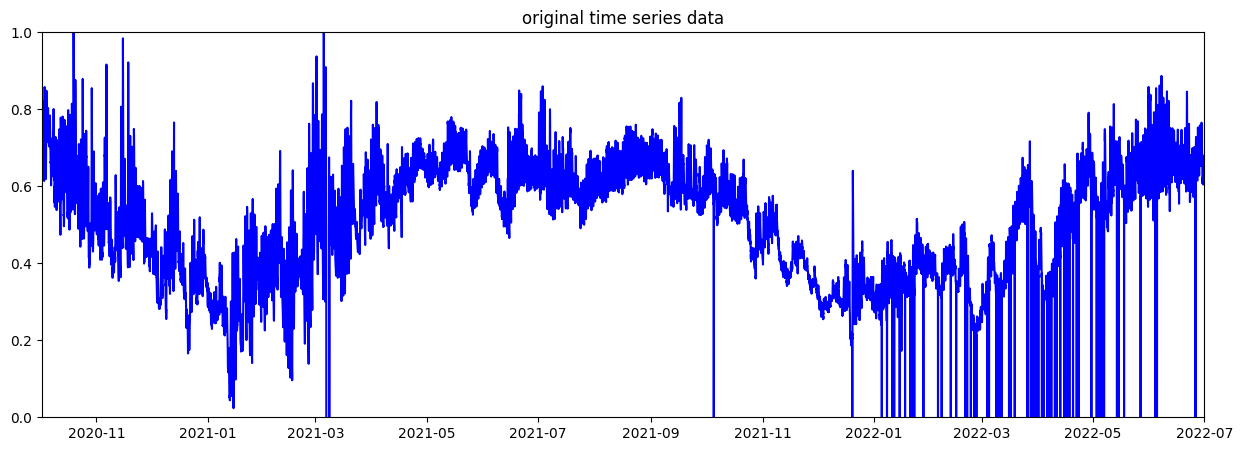

In [12]:
# plot the original time series and reconstructed segments

utils.plot_time_series(t, train, x_win=None, 
                       date_range=['2020-10-02', '2022-07-01'], value_range=[0, 1],
                       title='original time series data')

## Generate Reconstructed Time Series


In [13]:
# generate reconstructed time series segments
x_win_recon, critic_scores = model.predict(x_win)

In [10]:
print(critic_scores)

[4.9387226 4.752864  4.601857  ... 4.909561  4.8350763 4.8291893]


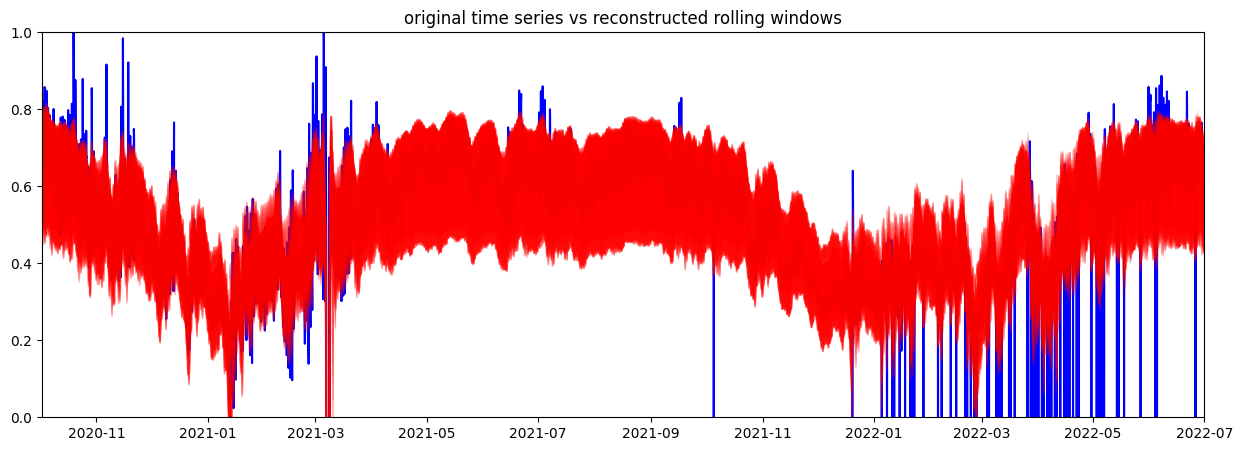

In [14]:
# plot the original time series and reconstructed segments

utils.plot_time_series(t, train, x_win=x_win_recon, 
                       date_range=['2020-10-02', '2022-07-01'], value_range=[0, 1],
                       title='original time series vs reconstructed rolling windows')

In [15]:
# apply postprocessing pipeline to obtain anomalous intervals

params = {
    'recon_score_params': RECON_SCORE_PARAMS,
    'anomalous_seq_params': ANOMALOUS_SEQ_PARAMS
}

detected_intervals, _, _ = postprocessing.apply_pipeline(train, t, x_win_recon, critic_scores, **params)
detected_intervals = detected_intervals[['start', 'end']].to_numpy()

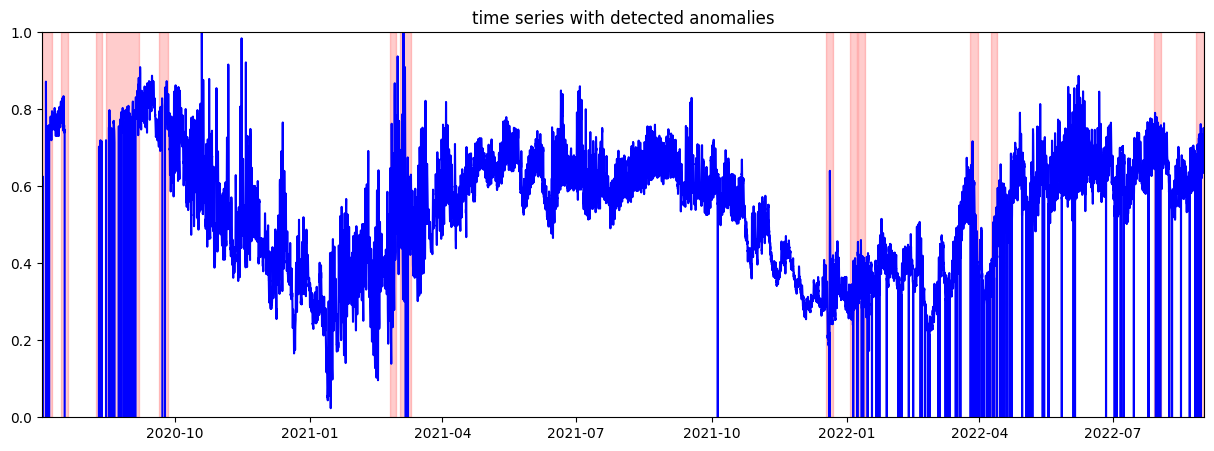

In [16]:
# plot time series with detected anomalies

utils.plot_time_series(t, train, detected_intervals=detected_intervals,
                       value_range=[0, 1], title='time series with detected anomalies')

In [34]:
test_model, t, x_win_test, t_win_test = preprocessing.apply_pipeline(test, freq=RESAMPLE_FREQ, window_size=WINDOW_SIZE)

In [35]:
x_win_recon_test, critic_scores_test = model.predict(x_win_test)

In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(x_win_test, x_win_recon_test)
mae = mean_absolute_error(x_win_test, x_win_recon_test)
r2 = r2_score(x_win_test, x_win_recon_test)
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R Squared (R2):", r2)

Mean Squared Error (MSE): 0.03469282217892352
Mean Absolute Error (MAE): 0.10864650637070725
R Squared (R2): 0.5192465415856207


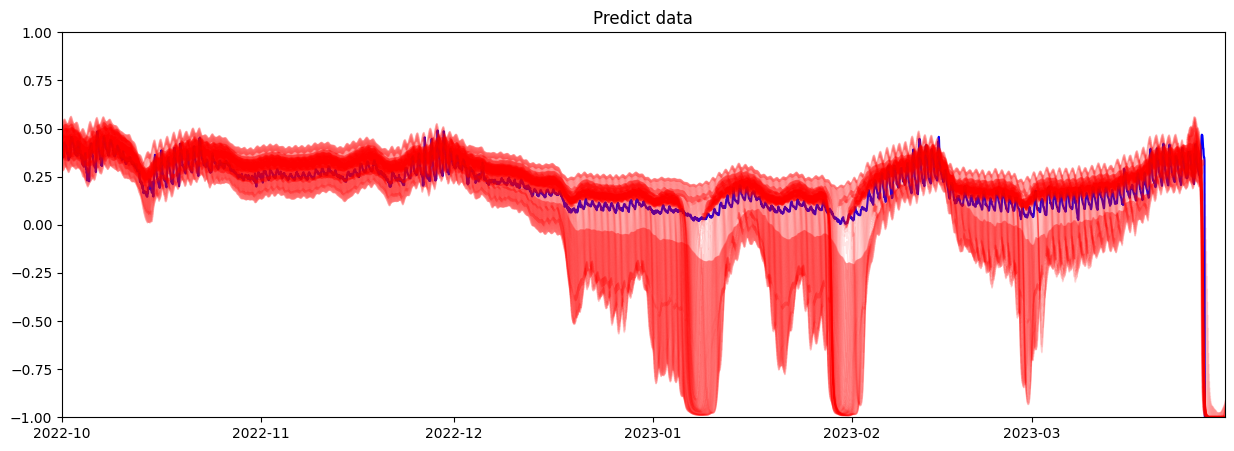

In [38]:
# plot the original time series and reconstructed segments

utils.plot_time_series(t, test_model, x_win=x_win_recon_test, 
                       date_range=['2022-10-01', '2023-03-31'], value_range=[-1, 1],
                       title='Predict data')

In [40]:
# apply postprocessing pipeline to obtain anomalous intervals

params = {
    'recon_score_params': RECON_SCORE_PARAMS,
    'anomalous_seq_params': ANOMALOUS_SEQ_PARAMS
}

detected_intervals, _, _ = postprocessing.apply_pipeline(test_model, t, x_win_recon_test, critic_scores_test, **params)
detected_intervals = detected_intervals[['start', 'end']].to_numpy()

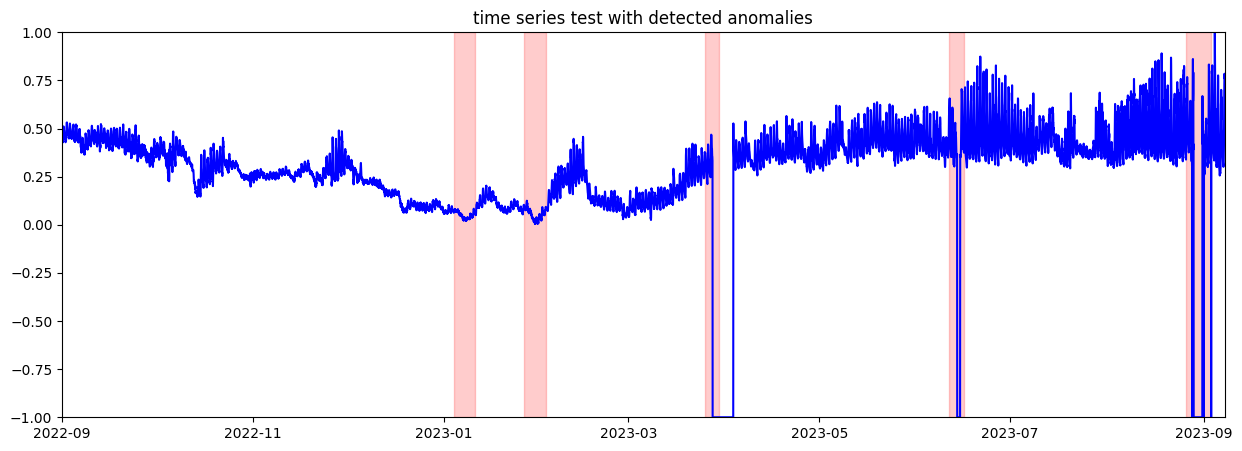

In [41]:
# plot time series with detected anomalies

utils.plot_time_series(t, test_model, detected_intervals=detected_intervals,
                       value_range=[-1, 1], title='time series test with detected anomalies')